# Powell Goggles

This is a quick project in which I first build, and then spoof, a simple facial-recognition program.

I'll train a machine learning algorithm to correctly identify photographs of several politicians, and then design a special pair of sunglasses which trick the program into misidentifying George W. Bush as Colin Powell.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

## First, download a dataset of labeled faces

I'll use scikit-learn's LFW dataset, which I think stands for "labeled faces in the wild:"

In [2]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)

In [3]:
image_shape = faces.images[0].shape

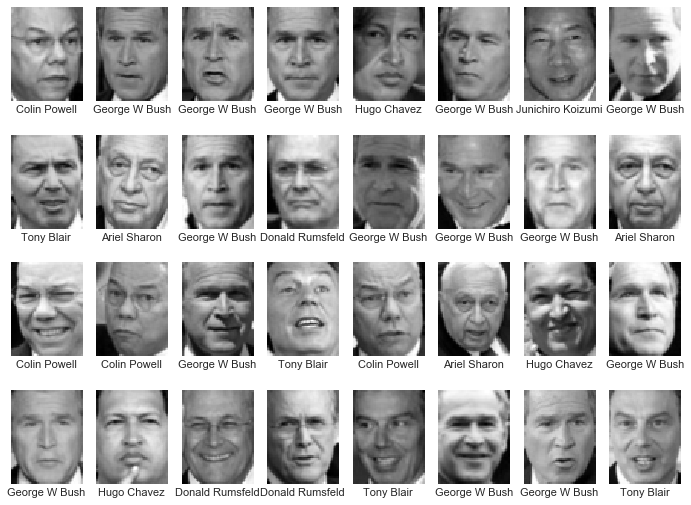

In [4]:
fig, axs = plt.subplots(4, 8, figsize=(12, 9))
for i, ax in enumerate(axs.flat):
    ax.imshow(faces.images[i], cmap='gray')
    ax.set(xticks=[], yticks=[],
           xlabel=faces.target_names[faces.target[i]])

## Next, build a simple facial recognition program:

This is heavily based on an example from Jake Vanderplas's *Data Science Handbook*.

I'll use a principal component analysis to reduce the dimensionality of the data, and then train a support vector machine to classify images in this reduced space:

In [5]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

pca = PCA(n_components=150, whiten=True, svd_solver='randomized', random_state=42)
svc = SVC(class_weight='balanced', probability=True)
model = make_pipeline(pca, svc)

The PCA algorithm has no free parameters, but we need to find the optimal parameter choices for the SVC.  I'll use scikit-learn's "GridSearchCV" to try a grid of parameter choices and take the best set:

In [6]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(faces.data, faces.target, random_state=42)

In [7]:
from sklearn.model_selection import GridSearchCV
param_grid = {'svc__kernel': ['rbf', 'linear', 'poly', 'sigmoid'],
              'svc__C': [1, 3, 10, 30],
              'svc__gamma': [0.0001, 0.0003, 0.001, 0.003]}
grid = GridSearchCV(model, param_grid, return_train_score=True)

In [8]:
%time grid.fit(Xtrain, ytrain)
print grid.best_params_

CPU times: user 4min 20s, sys: 4.64 s, total: 4min 25s
Wall time: 3min 14s
{'svc__gamma': 0.003, 'svc__kernel': 'rbf', 'svc__C': 3}


In [9]:
model = grid.best_estimator_
yfit = model.predict(Xtest)

We can get a quick sense for how the model performs by looking at a few of its identifications:

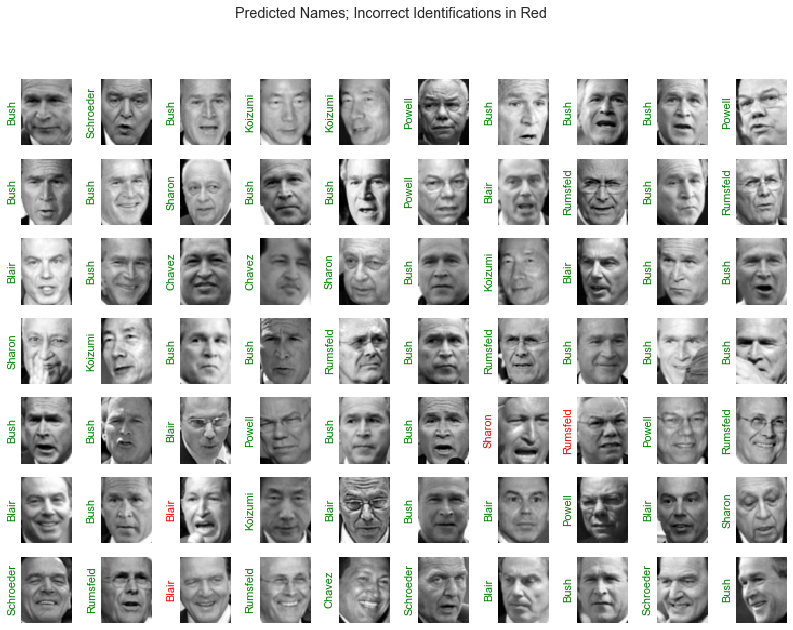

In [10]:
fig, axs = plt.subplots(7, 10, figsize=(14,10))
for i, ax in enumerate(axs.flat):
    ax.imshow(Xtest[i].reshape(*image_shape), cmap='gray')
    ax.set(xticks=[], yticks=[])
    ax.set_ylabel(faces.target_names[yfit[i]].split()[-1],
                  color='green' if yfit[i] == ytest[i] else 'red')
    
fig.suptitle('Predicted Names; Incorrect Identifications in Red');

Or we can assess the performance of the model more quantitatively:

In [11]:
from sklearn.metrics import classification_report

print classification_report(ytest, yfit, target_names=faces.target_names)

                   precision    recall  f1-score   support

     Ariel Sharon       0.75      0.80      0.77        15
     Colin Powell       0.85      0.90      0.87        68
  Donald Rumsfeld       0.81      0.81      0.81        31
    George W Bush       0.93      0.92      0.92       126
Gerhard Schroeder       0.90      0.83      0.86        23
      Hugo Chavez       1.00      0.75      0.86        20
Junichiro Koizumi       0.92      1.00      0.96        12
       Tony Blair       0.89      0.93      0.91        42

      avg / total       0.89      0.89      0.89       337



Pretty neat!  With just a few lines of code, we have a facial recognition program which correctly identifies politicians about 90% of the time!  We can also use a confusion matrix to get a better sense of how it goes wrong:

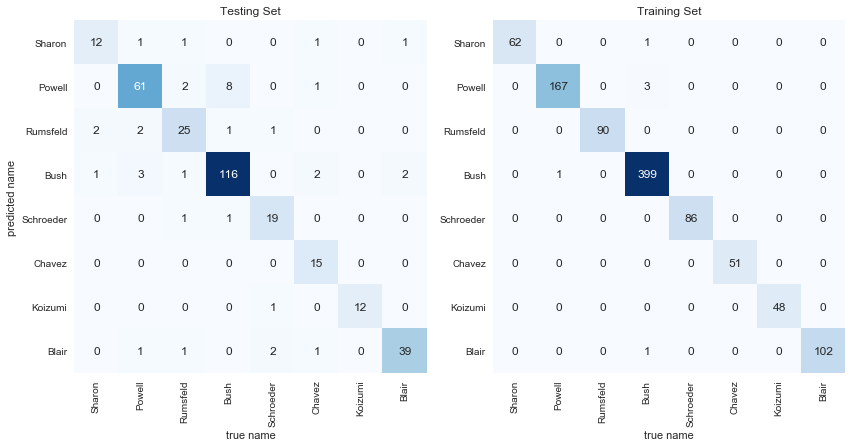

In [12]:
from sklearn.metrics import confusion_matrix

# keep only the last name to save space
labels = [ n.split()[-1] for n in faces.target_names ]

fig, axs = plt.subplots(1, 2, figsize=(12,12))

mat = confusion_matrix(ytest, yfit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, cmap='Blues', ax=axs[0],
            xticklabels=labels,
            yticklabels=labels)

axs[0].set_title('Testing Set')

mat = confusion_matrix(ytrain, model.predict(Xtrain))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, cmap='Blues', ax=axs[1],
            xticklabels=labels,
            yticklabels=labels)

axs[1].set_title('Training Set')

for ax in axs:
    ax.set_xlabel('true name');
    ax.set_ylabel('predicted name');
    
axs[1].set_ylabel('');
    
fig.tight_layout();

## Now that we have a working facial recognition program, we can try to fool it

We'll look for a small change we can add to an image of Bush, which causes our program to classify the image as one of Powell.  First, we need to understand the types of image features that our program is sensitive to:

In [13]:
pca.fit(faces.data)

PCA(copy=True, iterated_power='auto', n_components=150, random_state=42,
  svd_solver='randomized', tol=0.0, whiten=True)

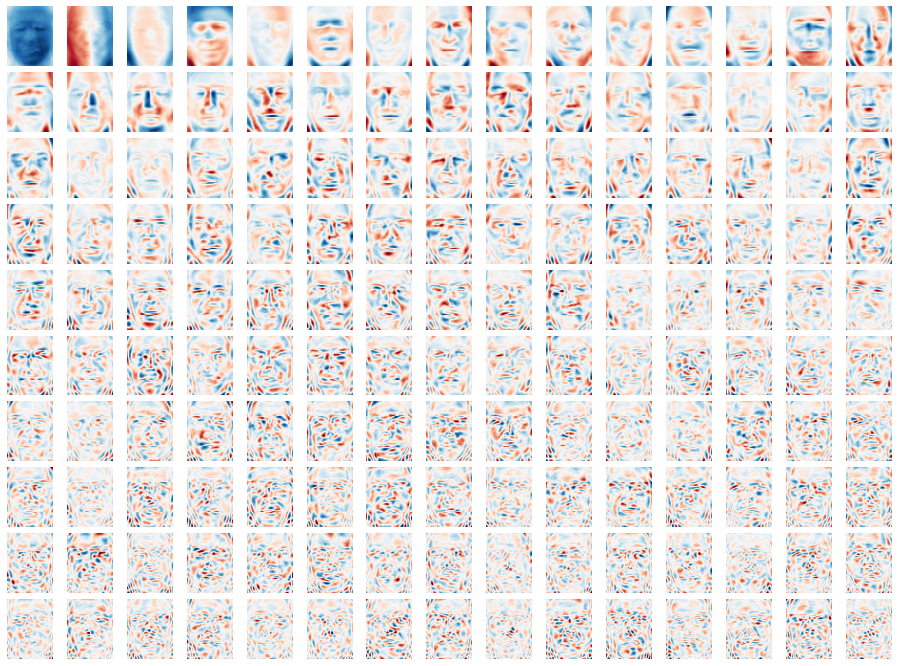

In [14]:
fig, axs = plt.subplots(10, 15, figsize=(16, 12),
                        subplot_kw={'xticks':[], 'yticks':[]},
                        gridspec_kw=dict(hspace=0.1, wspace=0.1))

for i, ax in enumerate(axs.flat):
    lim = np.max(np.abs(pca.components_[i]))
    ax.imshow(pca.components_[i].reshape(*image_shape), cmap='RdBu_r', vmin=-lim, vmax=lim)

The first 5 principal components seem to relate to lighting effects such as overall brightness and the direction of the light source.  Beyond that, we start to see features which pick out eyes, noses, chins, jawlines, etc... these are the features which most likely go into facial recognition.  Fortunately for us, these features are all highly non-local and tend to ripple out across the entire image.

We'll need to design a pattern which does not look like Colin Powell's face, but which overlaps with some of the main features associated with Powell's images.

Next, I'll use this pattern to design a set of special glasses which can trick the program into classifying images of George Bush as Colin Powell.

Here's what our dataset looks like:

In [15]:
bush   = faces.data[faces.target_names[faces.target] == 'George W Bush']
powell = faces.data[faces.target_names[faces.target] == 'Colin Powell']

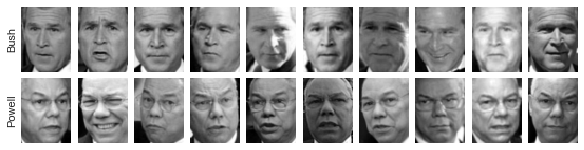

In [16]:
fig, ax = plt.subplots(2, 10, figsize=(10, 2.5),
                       subplot_kw={'xticks':[], 'yticks':[]},
                       gridspec_kw=dict(hspace=0.1, wspace=0.1))

for i in range(10):
    ax[0,i].imshow(bush[i].reshape(*image_shape), cmap='gray')
    ax[1,i].imshow(powell[i].reshape(*image_shape), cmap='gray')
    
ax[0,0].set_ylabel('Bush');
ax[1,0].set_ylabel('Powell');

Next, we can see how well our program separates these images of Bush and Powell:

In [17]:
ibush   = list(faces.target_names).index('George W Bush')
ipowell = list(faces.target_names).index('Colin Powell')

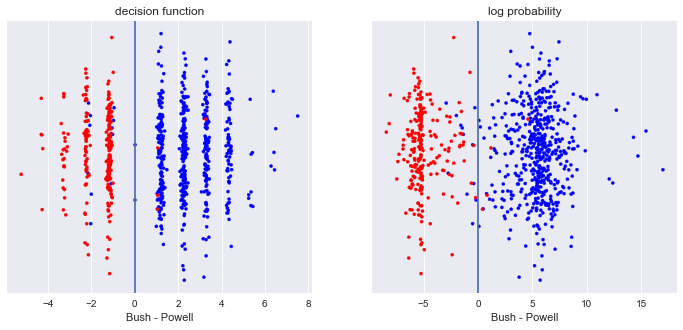

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(12,5))

# v represents "bush - powell"
v = model.decision_function(np.vstack([bush, powell]))
v = v[:,ibush] - v[:,ipowell]

# random variable to plot on y
y = np.random.normal(size=len(v))

axs[0].scatter(v, y, s=10, color=['b']*len(bush) + ['r']*len(powell));
axs[0].set_title('decision function');

# v represents "bush-ness"
v = model.predict_log_proba(np.vstack([bush, powell]))
v = v[:,ibush] - v[:,ipowell]

axs[1].scatter(v, y, s=10, color=['b']*len(bush) + ['r']*len(powell));
axs[1].set_title('log probability');

for ax in axs:
    ax.set_yticks([])
    ax.set_xlabel('Bush - Powell')
    ax.axvline(x=0)

In both cases, we can see that the model separates the Bush images (blue) from the Powell images (red) pretty well.  I'll work with probability since it does a slightly better job in separating Bush from Powell.  It's also more continuous than the decision function, and therefore should be easier to differentiate and perturb:

In [19]:
def lnprob_bush(data):
    """For a given image represented by data, return
    log(P(Bush | data)) - log(P(Powell | data)).  Positive values mean the
    image is identified as Bush; negative values mean the image is identified
    as Powell."""
    v = model.predict_log_proba([data])[0]
    return v[ibush] - v[ipowell]

In [20]:
def lnprob(data, v):
    """Function to minimize in order to fool the face recognition software."""
    corr = v[:,np.newaxis] * pca.components_
    corr = np.sum(corr, axis=0)
    lp = lnprob_bush(data + corr)
    
    # try to make lp = -1 (ie, 3:1 odds for Powell)
    return (lp + 1)**2

We'll try spoofing a random (say, the 100th) image of Bush, with a random guess for the initial perturbation:

In [21]:
from scipy.optimize import minimize
res = minimize(lambda(v): lnprob(bush[100], v), np.random.normal(size=150))
print res.success

True


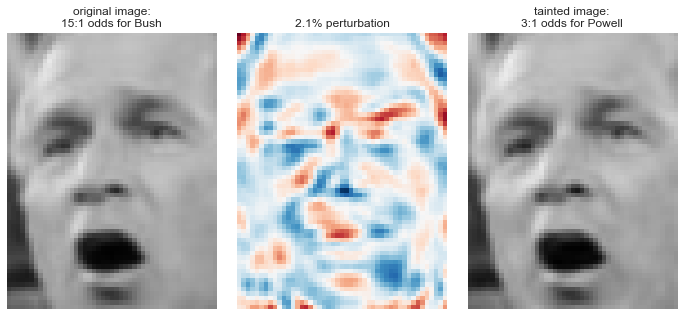

In [22]:
fig, axs = plt.subplots(1, 3, figsize=(12,12),
                       subplot_kw={'xticks':[], 'yticks':[]},
                       gridspec_kw=dict(hspace=0.1, wspace=0.1))

# manually sum the components to get a correction term:
# (alternatively, I could use the PCA inverse transform!)
corr = res.x[:,np.newaxis] * pca.components_
corr = np.sum(corr, axis=0)

# apply the correction to get a new image:
new = bush[100] + corr

axs[0].imshow(bush[100].reshape(*image_shape), cmap='gray', vmin=0, vmax=256);
axs[1].imshow(corr.reshape(*image_shape), cmap='RdBu_r');
axs[2].imshow(new.reshape(*image_shape), cmap='gray', vmin=0, vmax=256);

pbush = int(np.round(np.exp(lnprob_bush(bush[100]))))
axs[0].set_title('original image:\n{0:d}:1 odds for Bush'.format(pbush));

rms = np.sqrt(np.mean(corr**2))
axs[1].set_title('{0:.1f}% perturbation'.format(100 * rms / 256));

ppowell = int(np.round(np.exp(-lnprob_bush(new))))
axs[2].set_title('tainted image:\n{0:d}:1 odds for Powell'.format(ppowell));

So painting a *tiny* pattern on top of a picture of Bush can fool our program, without noticeably changing the image at all (at least to human eyes).  A 2.5% change to the pixel brightnesses is all it takes.

This suggests that spoofing the facial recognition program is possible, and probably not very difficult.  But painting your face is hard... let's see if we can design special sunglasses which can do it!

I'll use an image of some RayBan Wayfarers, and use it to design a mask for the PCA components:

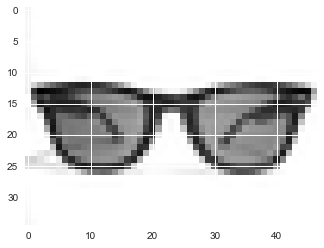

In [23]:
from PIL import Image

raybans = Image.open('rayban.jpg').convert('LA')
raybans.thumbnail(image_shape[::-1], Image.ANTIALIAS)

plt.imshow(raybans);

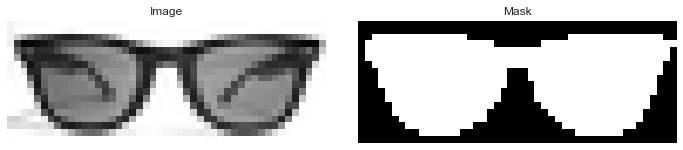

In [24]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6),
                        subplot_kw={'xticks':[], 'yticks':[]},
                        gridspec_kw=dict(hspace=0.1, wspace=0.1))

# manually crop the image and threshold the brightness level
new = np.asarray(raybans)[10:28,:,0]
raybans_mask = (new < 180).astype(int)

axs[0].imshow(new, cmap='gray');
axs[1].imshow(raybans_mask, cmap='gray');

axs[0].set_title('Image');
axs[1].set_title('Mask');

Now, we'll position this mask so that it roughly covers the eyes in our images:

In [25]:
# pick a random image of Bush
face = bush[327].reshape(*image_shape)

In [26]:
top = 13
raybans_mask = np.vstack([np.zeros((top, 47)), raybans_mask, np.zeros((62-top-18, 47))])
print raybans_mask.shape
print image_shape

(62, 47)
(62, 47)


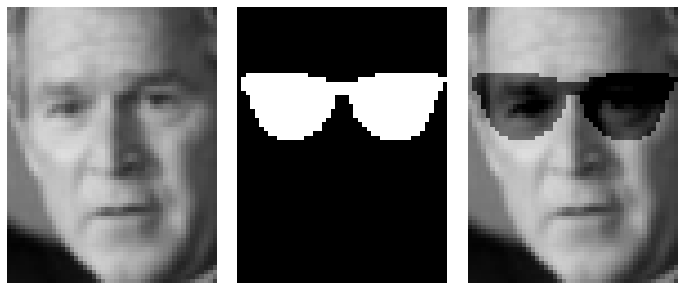

In [27]:
fig, axs = plt.subplots(1, 3, figsize=(12, 8),
                        subplot_kw={'xticks':[], 'yticks':[]},
                        gridspec_kw=dict(hspace=0.1, wspace=0.1))

axs[0].imshow(face, cmap='gray', vmin=0, vmax=256)
axs[1].imshow(raybans_mask, cmap='gray')
axs[2].imshow(face - 100 * raybans_mask, cmap='gray', vmin=0, vmax=256);

looking good!

We'll modify the PCA components to only modify the region covered by the sunglasses:

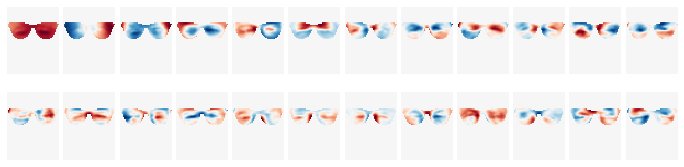

In [28]:
eigenshades = pca.components_ * raybans_mask.flat

fig, axs = plt.subplots(2, 12, figsize=(12, 3),
                        subplot_kw={'xticks':[], 'yticks':[]},
                        gridspec_kw=dict(hspace=0.1, wspace=0.1))

for i, ax in enumerate(axs.flat):
    lim = np.max(np.abs(eigenshades[i]))
    ax.imshow(eigenshades[i].reshape(*image_shape), cmap='RdBu', vmin=-lim, vmax=lim)

(A data scientist might call these *eigen-shades*, though they're not orthonormal, and they don't span the basis).

Now all we have to do is add up these eigen-shades to create a pattern which makes our program misidentify Bush as Powell:

In [29]:
def lnprob(bush_img, v):
    # sum up the correction
    corr = v[:,np.newaxis] * eigenshades
    corr = np.sum(corr, axis=0)
    
    # add the correction to the bush image and run our classifier on the result
    lp = lnprob_bush(bush_img + corr)
    
    # try to make lp = -0.5 (ie, 2:1 odds for Powell)
    return (lp + 0.5)**2

In [30]:
def make_powell_goggles(bush_img):
    # bush with shades
    shades = bush_img - 100 * raybans_mask.flatten()
    
    # find the correction which triggers mis-identification
    res = minimize(lambda(v): lnprob(shades, v), np.random.normal(size=150))
    
    # add the correction:
    corr = res.x[:,np.newaxis] * eigenshades
    corr = np.sum(corr, axis=0)
    new  = shades + corr
    
    # plot each of them
    fig, axs = plt.subplots(1, 4, figsize=(12,12),
                            subplot_kw={'xticks':[], 'yticks':[]},
                            gridspec_kw=dict(hspace=0.1, wspace=0.1))

    axs[0].imshow(bush_img.reshape(*image_shape), cmap='gray', vmin=0, vmax=256);
    axs[1].imshow(shades.reshape(*image_shape),   cmap='gray', vmin=0, vmax=256);
    axs[2].imshow(corr.reshape(*image_shape),     cmap='RdBu_r');
    axs[3].imshow(new.reshape(*image_shape),      cmap='gray', vmin=0, vmax=256);

    pbush = int(np.round(np.exp(lnprob_bush(bush_img))))
    axs[0].set_title('{0:d}:1 odds for Bush'.format(pbush));
    
    pbush = int(np.round(np.exp(lnprob_bush(shades))))
    axs[1].set_title('{0:d}:1 odds for Bush'.format(pbush));
    
    axs[2].set_title('Printed Pattern')

    ppowell = int(np.round(np.exp(-lnprob_bush(new))))
    axs[3].set_title('{0:d}:1 odds for Powell'.format(ppowell));

Try it out on a sample of Bush images:

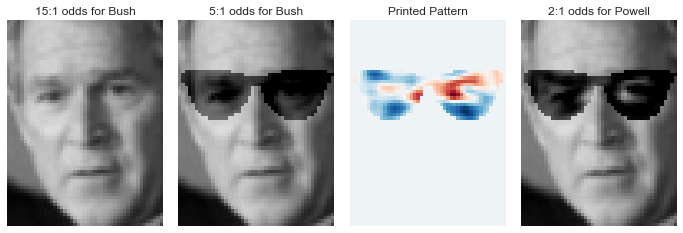

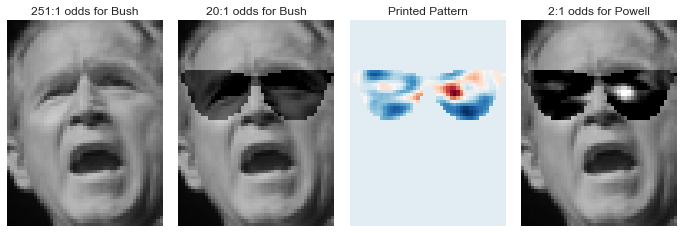

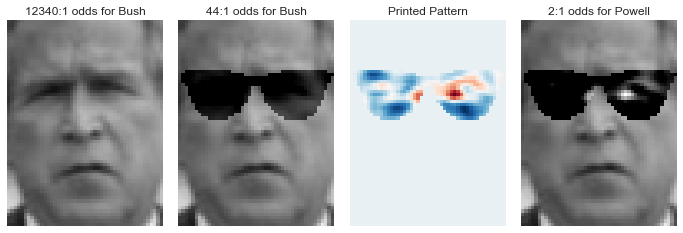

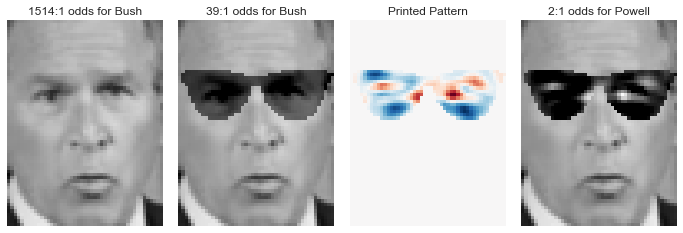

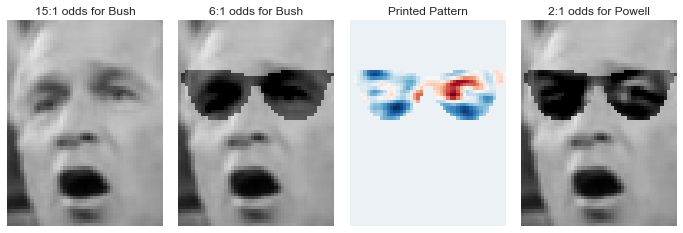

In [31]:
for i in (327, 320, 207, 340, 100):
    make_powell_goggles(bush[i])

In every case, we can design glasses which fool the facial recognition program... even when the initial determination is quite secure, with initial odds of 100s to 1 or in some cases 6500:1!

Interestingly, the glasses on their own are not enough to spoof the program... you really do need the special pattern to be printed on them.  (So much for the spy movies where characters wear sunglasses and hats to evade detection!)

It's also interesting that the printed pattern looks somewhat innocuous... almost like a reflection over the right eye.  The printed pattern looks quite similar in all cases, so it seems likely we could design a single pair of sunglasses which would work for all (or at least most) of the images.  I'll try this next:

In [32]:
def make_powell_goggles(bush_img):
    # bush with shades
    shades = bush_img - 100 * raybans_mask.flatten()
    
    # find the best correction which triggers misidentification
    res = minimize(lambda(v): lnprob(shades, v), np.random.normal(size=150))
    
    return (res.success, res.x)

In [33]:
%timeit make_powell_goggles(bush[240])

1 loop, best of 3: 3.32 s per loop


We'll average 30 sets of Powell-Goggles, and hope the result works with the rest of the images of Bush:

In [34]:
ind = np.random.choice(np.arange(bush.shape[0]), size=30)

In [35]:
%time data = [ make_powell_goggles(bush[i]) for i in ind ]

CPU times: user 1min 36s, sys: 736 ms, total: 1min 36s
Wall time: 1min 37s


In [36]:
goggles = np.asarray([ d for success, d in data if success ])
goggles = np.mean(goggles, axis=0)

In [38]:
def get_prob(bush_img):
    shades = bush_img - 100 * raybans_mask.flatten()

    corr = goggles[:,np.newaxis] * eigenshades
    corr = np.sum(corr, axis=0)

    new = shades + corr
    
    return (lnprob_bush(bush_img), lnprob_bush(new))

In [39]:
%timeit get_prob(bush[234])

100 loops, best of 3: 1.87 ms per loop


In [40]:
data = [ get_prob(bush[i]) for i in np.arange(bush.shape[0]) ]

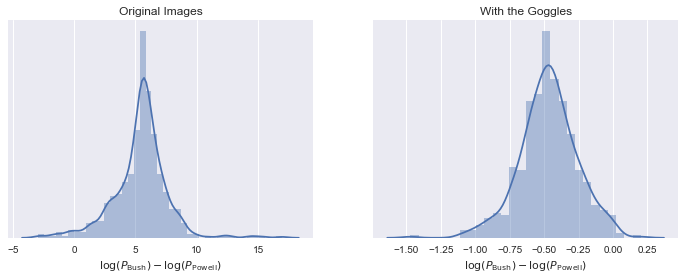

In [41]:
orig = [ o for o, n in data ]
new  = [ n for o, n in data ]

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].set_title('Original Images')
axs[1].set_title('With the Goggles')

for vals, ax in zip((orig, new), axs):
    sns.distplot(vals, ax=ax)
    ax.set_yticks([])
    ax.set_xlabel('$\log(P_{\mathrm{Bush}}) - \log(P_{\mathrm{Powell}})$')

So it works!  We can see that the typical bush image is correctly identified with odds of $\sim\exp(5)\sim{150:1}$.  After applying our goggles, virtually all of our images are classified as Powell.

For posterity, here are the goggles:

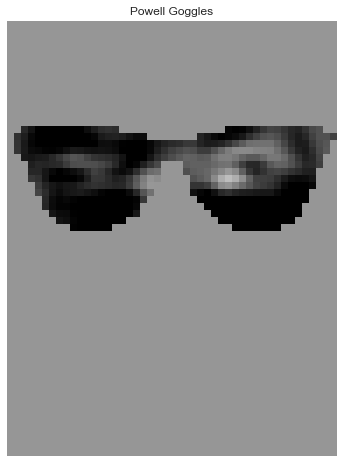

In [42]:
shades = 150 - 100 * raybans_mask.flatten()

corr = goggles[:,np.newaxis] * eigenshades
corr = np.sum(corr, axis=0)

plt.figure(figsize=(8,8))
plt.imshow((shades + corr).reshape(*image_shape), cmap='gray', vmin=0, vmax=256)
plt.xticks([])
plt.yticks([]);
plt.title('Powell Goggles');

Interestingly, they look fairly innocuous... this pattern looks like it could be a reflection.  We didn't have to paint a recognizable image of Powell's eyes onto the glasses in order to fool the facial recognition program into thinking it's looking at a picture of Powell; rather, we just have a pattern of bright and dark spots which happen to tickle the same PCA components and Powell's features.  While my facial recognition program is rather simplistic, this is a general weakness of algorithms which use non-local basis functions in their analysis... I suspect many, if not most, facial recognition algorithms are susceptible to this type of attack.

Also note that these googles are quite robust in their ability to fool the facial recognition program.  Painting this pattern on a pair of Ray-Bans would absolutely work, at least for my simple program!